#### 2020-10-29

# Analyzing movies from eve stripe 2 MS2 constructs with variable length lacZ transcripts

Picking up from notebook 12. Goal is to look at the change (if any) in pol2 signal at the transcription site. The signal due to elongating pol2 molecules should decrease proportionally with the "lost" transcript (there is some variable of time spent by the polymerase on different parts of the gene). Right now, I'm having trouble even hammering down a change in MS2 signal, which would appear to be step 1...

In [3]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

In [125]:
#long1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20201005-rpb1eS2-3kb-em2-zsmv-03-04.pkl')
#long2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20201005-rpb1eS2-3kb-em4-zsmv-03-04.pkl')
long3 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20201007-rpb1eS2-3kb-em2-zsmv-01-03.pkl')
long4 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20201007-rpb1eS2-3kb-em4-zsmv-03.pkl')

In [126]:
#short1 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200923-rpb1eS2-1p9kb-em1-zsmv-02-06.pkl')
#short2 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200923-rpb1eS2-1p9kb-em2-zsmv-01-02.pkl')
short3 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200923-rpb1eS2-1p9kb-em3-zsmv-03-06.pkl')
short4 = load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20200923-rpb1eS2-1p9kb-em4-zsmv-04-05.pkl')

OK, how about this. 

1) Do a bleaching correction for each frame (based on frame mean to start).   
2) Filter for trajectory length.  
3) Look at the mean (maybe other features) for each spot (and the distribution of spot intensities). 

3849.5183209298775


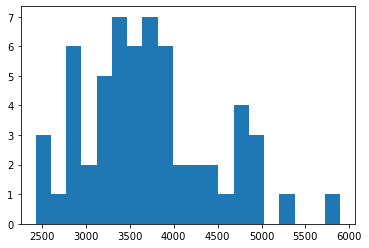

In [57]:
def bleach_corrs(mv, c):
    """Finds correction factors for each frame to equalize the frame means (for a single channel)"""
    stack = mv.stack.copy()
    stack_corr = stack[c].copy()
    corrs = []
    c_mean = np.mean(stack[c])
    for f in range(0, stack.shape[1]):
        f_mean = np.mean(stack[c, f])
        corr = c_mean/f_mean
        corrs.append(corr)
        stack_corr[f] = stack_corr[f] * corr
    return c_mean, corr

def filter_df_minlen(df, minlen):
    """Filter dataframe to retain only columns that contain >= minlen non NaN values"""
    df_f = df.copy()
    def test(x):
        if (np.count_nonzero(~np.isnan(x)) >= minlen):
            return True
        return False
    boolean = df_f.apply(test, axis=0)
    df_f = df_f.iloc[:,np.where(boolean)[0]]
    df_f.columns=np.arange(1, df_f.shape[1]+1)
    return df_f

def f2(mv, p_channel=0, m_channel=1, minlen=20):
    m_mean, m_corrs = bleach_corrs(mv, m_channel)
    intvol_cor = mv.intvol.multiply(m_corrs, axis="rows")
    intvol_cornorm = intvol_cor / m_mean * 1000
    intvol_fil = filter_df_minlen(intvol_cornorm, minlen)
    print(np.nanmean(intvol_fil.values.flatten()))
    means = intvol_fil.mean(axis=0)
    plt.hist(means, histtype='stepfilled', bins=20);

f2(long1)



3278.628365473593


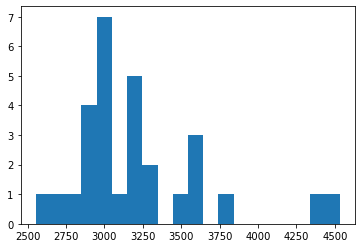

In [58]:
f2(long2)

3603.6976221601676


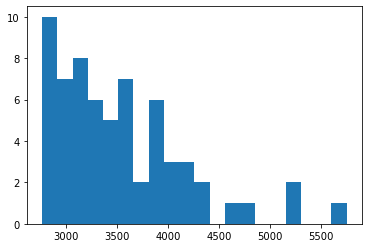

In [59]:
f2(short1)

3286.5854315299516


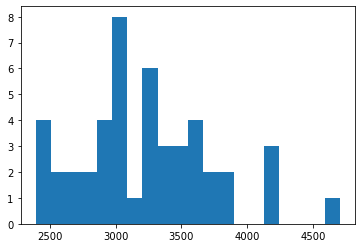

In [60]:
f2(short2)

Hmm. Unclear if this is right...How about going back to the radial plot style approach with normalization. Start with normalizing by just dividing each frame by its mean (and multiplying by some constant).

Actually, scratch that. Trying to normalize the datasets vs. each other seems hard or impossible. I think we are going to have to take advantage of internal normalization, comparing MS2 and protein signals. Let's explore some.

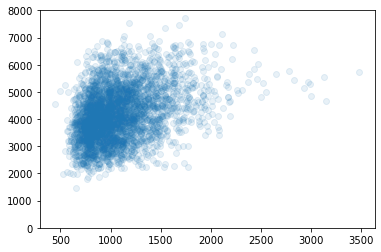

In [78]:
plt.scatter(short1.intvol.values.flatten(), short1.prot.values.flatten(), alpha=0.1);
plt.ylim(0,8000);

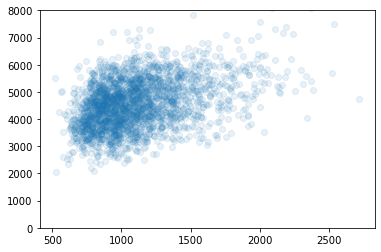

In [77]:
plt.scatter(short2.intvol.values.flatten(), short2.prot.values.flatten(), alpha=0.1);
plt.ylim(0,8000);

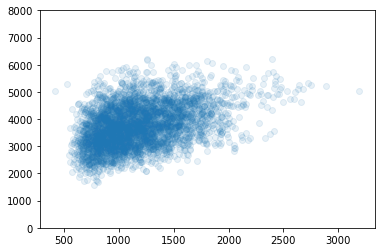

In [102]:
plt.scatter(long1.intvol.values.flatten(), long1.prot.values.flatten(), alpha=0.1);
plt.ylim(0,8000);

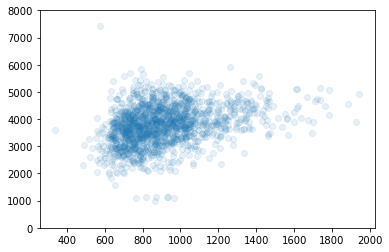

In [103]:
plt.scatter(long2.intvol.values.flatten(), long2.prot.values.flatten(), alpha=0.1);
plt.ylim(0,8000);

In [120]:
def plotpix(mv, minlen=20, ylim=7000):
    x = filter_df_minlen(mv.intvol, minlen).values.flatten()
    y = filter_df_minlen(mv.prot, minlen).values.flatten()

    x1 = x[~np.isnan(x)]
    y1 = y[~np.isnan(x)]

    x2 = x1[y1 < ylim]
    y2 = y1[y1 < ylim]

    m, b = np.polyfit(x2, y2, 1)
    print(m,b)
    plt.scatter(x,y);
    plt.plot(x, m*x + b, color="black");
    plt.ylim(0,ylim);


0.9931480464568432 3105.171654508907


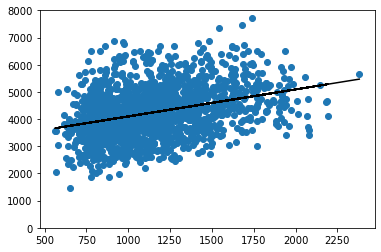

In [134]:
plotpix(short1, 40, 8000)

1.1502928785684137 3230.8613428567


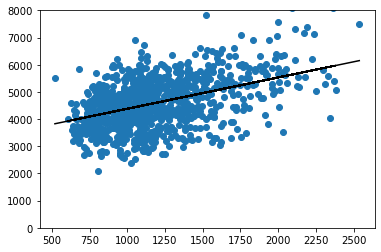

In [135]:
plotpix(short2, 40, 8000)

0.9912840609201679 2552.5867997615997


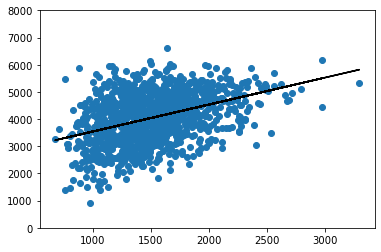

In [136]:
plotpix(short3, 40, 8000)

-0.5546487739596205 4581.122776730731


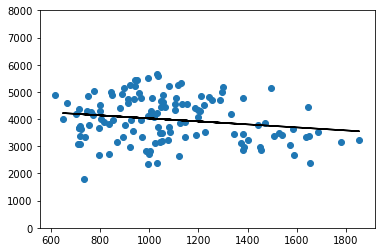

In [137]:
plotpix(short4, 40, 8000)

0.8410526342834704 2768.085016860027


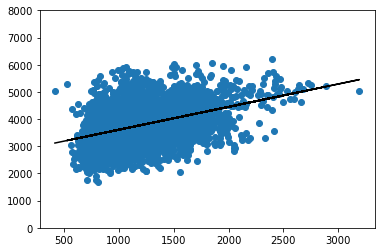

In [138]:
plotpix(long1, 40, 8000)

1.1307153691033407 2745.9467274397052


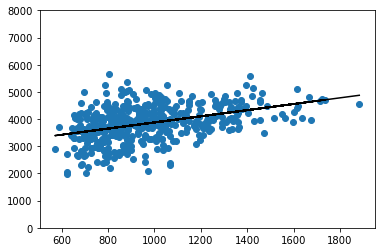

In [139]:
plotpix(long2, 40, 8000)

1.2235771692734612 3234.308281667317


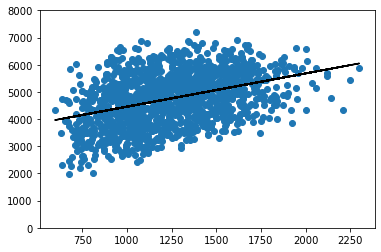

In [140]:
plotpix(long3, 40, 8000)

0.9072690009145801 3379.8318026268776


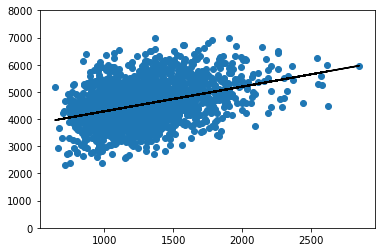

In [141]:
plotpix(long4, 40, 8000)

Huh. Hard to make much sense of that. It doesn't seem like using the slope will be exceptionally stable. Grrr. This is actually pretty tough. It's a little hard to know what the issues are. Two possibilities are movie-specific optical differences (e.g., different depths, opacity differences between embryos) and timing/positioning differences that result in different spot distributions. Optical differences should be able to be normalized away. Spot distributions are a bit harder. Subtle differences in timing and position could affect this. Because we are likely looking for small-size effects, these things become important. 

I wonder if it will be necessary to look at position within the stripe? The more I think on it, the more I think that spot-matching may be important. It may be important to do some kind of optical correction (maybe using some non-HLB-containing slices in the Rpb1 channel?) then matching spots based on position within stripes. Basically, being careful to compare apples to apples. The short story is if we can't see a difference in MS2 signal, there's no reason to believe anything coming out of the MS2-rpb1 association...I think. 

hello
